In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
left_img = cv2.imread('left.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('right.jpg', cv2.IMREAD_GRAYSCALE)

In [11]:
left_img = cv2.equalizeHist(left_img)
right_img = cv2.equalizeHist(right_img)

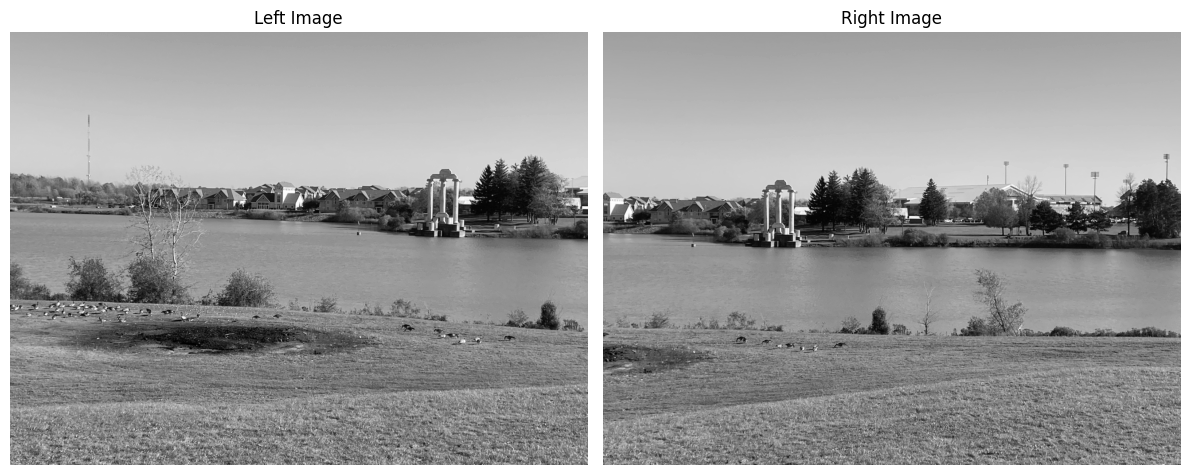

In [12]:

def show_stereo_images(left_img, right_img, cmap='gray', figsize=(12, 5), titles=('Left Image', 'Right Image')):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.title(titles[0])
    plt.imshow(left_img, cmap=cmap)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(titles[1])
    plt.imshow(right_img, cmap=cmap)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

left_img = cv2.imread('left.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('right.jpg', cv2.IMREAD_GRAYSCALE)

show_stereo_images(left_img, right_img)


In [13]:
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64,      
    blockSize=5,             
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    disp12MaxDiff=1,
    P1=8 * 3 * 5 ** 2,
    P2=32 * 3 * 5 ** 2
)

disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0


In [14]:
disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)


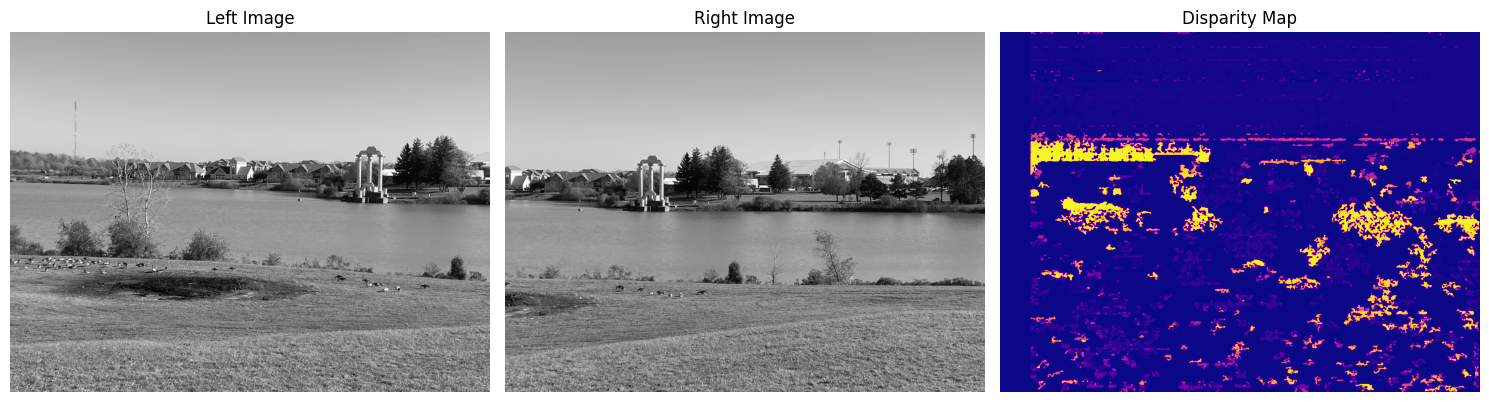

In [15]:
import matplotlib.pyplot as plt

def show_and_save_disparity_triplet(left_img, right_img, disparity_map,
                                     cmap_imgs='gray', cmap_disp='plasma',
                                     figsize=(15, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.title('Left Image')
    plt.imshow(left_img, cmap=cmap_imgs)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Right Image')
    plt.imshow(right_img, cmap=cmap_imgs)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Disparity Map')
    plt.imshow(disparity_map, cmap=cmap_disp)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('disparity_result2.png', dpi=300, bbox_inches='tight')  # <-- Save the figure
    plt.show()

show_and_save_disparity_triplet(left_img, right_img, disparity_normalized)

